In [1]:
from pymongo import MongoClient
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

import json
import datetime
import calendar
import time
import numpy as np
import scipy.stats as stats

In [2]:
#  Connect to the hosted MongoDB instance
client = MongoClient()

In [3]:
# Access already existing database
db = client['capstone1_bball_reference']

In [4]:
# Access already existing collection in database
all_seasons = db['all_seasons']

In [5]:
actual_links = db.all_seasons.distinct("link")

## Get HTML pages from MongoDB and parse with Beautiful Soup

In [6]:
def parse_to_df(links, starting_season,ending_season):
    
    date = []
    visiting = []
    visiting_score = []
    home = []
    home_score = []
    season = []
    notes = []
    
    for i,link in enumerate(links):
        
        if starting_season <= int(link.split("_")[1]) <= ending_season:
        
            sub_season = all_seasons.find_one({'link':link})['html']
            soup = BeautifulSoup(sub_season,'html.parser')

            for i,game in enumerate(soup.find_all('tr')):
                if game.a != None: #skips the chart label rows
                    datestring = game.find('a').text[5:]
                    dt = datetime.datetime.strptime(datestring,'%b %d, %Y') #change datestring to datetime object
                    date.append(dt)
                    visiting.append(game.find_all('td','left')[0].text)
                    home.append(game.find_all('td','left')[1].text)
                    season.append(soup.find_all('div','inactive')[0].find('li','index').text.rstrip())
                    notes.append(game.find_all('td','left')[-1].text)
                    if len(soup.find_all('col'))==10: #takes care of the different column counts 
                        if (game.find_all('td','right')[1].text) != '': #accommodates for games that were scheduled but never played have have no scores
                            visiting_score.append(int(game.find_all('td','right')[1].text))
                            home_score.append(int(game.find_all('td','right')[2].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                    else:
                        if (game.find_all('td','right')[0].text) != '':
                            visiting_score.append(int(game.find_all('td','right')[0].text))
                            home_score.append(int(game.find_all('td','right')[1].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                
    df = pd.DataFrame({'date':date,'season':season,'visiting_team':visiting,'visiting_score':visiting_score,
                  'home_team':home, 'home_score':home_score, 'notes':notes})
    return df

In [7]:
df = parse_to_df(actual_links, 2010, 2019)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12897 entries, 0 to 12896
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12897 non-null  datetime64[ns]
 1   season          12897 non-null  object        
 2   visiting_team   12897 non-null  object        
 3   visiting_score  12897 non-null  int64         
 4   home_team       12897 non-null  object        
 5   home_score      12897 non-null  int64         
 6   notes           12897 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 705.4+ KB


In [9]:
df.head()

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,


Drop rows with notes (these rows are where games are played elsewhere - not at either teams' arenas) and rows with 0's as scores (these games were scheduled but have not been played)

In [10]:
df[df.notes!='']['notes'].count()

17

In [11]:
df[df.visiting_score == 0]['visiting_score'].count()

7

In [12]:
filtered = df[(df.notes=='') & (df.visiting_score != 0)] # 10 seasons and 12478 played that we are considering
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,
...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,


array([[<AxesSubplot:xlabel='visiting_score', ylabel='visiting_score'>,
        <AxesSubplot:xlabel='home_score', ylabel='visiting_score'>],
       [<AxesSubplot:xlabel='visiting_score', ylabel='home_score'>,
        <AxesSubplot:xlabel='home_score', ylabel='home_score'>]],
      dtype=object)

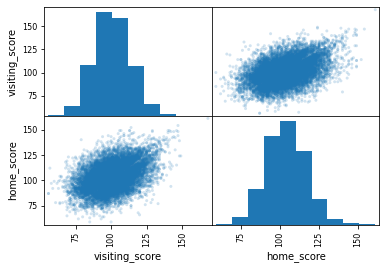

In [13]:
pd.plotting.scatter_matrix(filtered, alpha = 0.2)

At first glance at the histograms it looks like majority of the scores of the visiting teams are just left of 100 points vs. scores of the home teams are just right of 100. They look normally distributed.

## Figure out how many home wins vs visitor wins there are by season and graph it

Approach - create two new columns, home_win and visitor_win, and assign a 1 to the column depending on the winner of the game. This will allow me to do a group by season and sum up the wins per column 

In [14]:
filtered['home_win'] = np.where(filtered['home_score']>filtered['visiting_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
filtered['visitor_win'] = np.where(filtered['visiting_score']>filtered['home_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,,0,1
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,,1,0
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,,1,0
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,,0,1
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,,0,1
...,...,...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,,1,0
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,,0,1
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,,1,0
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,,1,0


In [17]:
total_home_wins = filtered[filtered.home_win==1]['home_team'].count()
total_home_wins

7626

In [18]:
total_games = filtered.shape[0]
total_games

12873

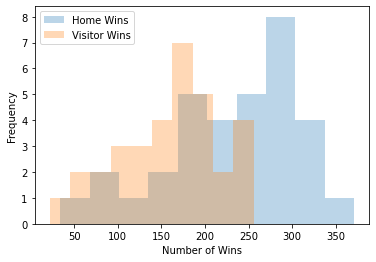

In [19]:
home_wins = filtered.groupby('home_team')[['home_team','home_win']].sum()
visitor_wins = filtered.groupby('visiting_team')[['visiting_team','visitor_win']].sum()
fig, ax = plt.subplots()
ax.hist(home_wins,alpha=0.3,bins=10,label="Home Wins")
ax.hist(visitor_wins,alpha=0.3,bins=10,label="Visitor Wins")
ax.set_xlabel('Number of Wins')
ax.set_ylabel('Frequency')
ax.legend();

## One Sample Test of Population Proportions
* Scientific Question - Is home court advantage real?
* Null Hypothesis: There is no such thing as a home court advantage. Home teams win 50% of the games. p =0.5
* Alternative Hypothesis: There is such a thing as home court advantage. Home teams win more than 50% of the games.
* Test statistic: number of games won by home teams (observed = 7626 home wins/12873)
* Significance level: 0.05
* Distribution of the null
    * Binomial where n = 12873 games p = 0.5

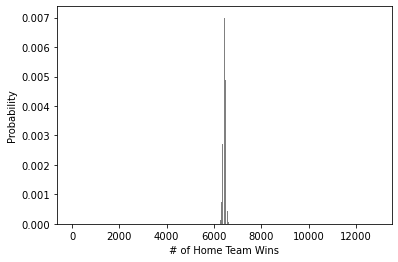

In [20]:
binomial = stats.binom(n=total_games, p=0.5)

fig, ax = plt.subplots()
bars = ax.bar(range(total_games+1), [binomial.pmf(i) for i in range(total_games+1)], color="grey")
ax.set_xlabel('# of Home Team Wins')
ax.set_ylabel('Probability');

In [21]:
prob_equal_or_more_extreme = 1 - binomial.cdf(total_home_wins-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 1.1e-16


Reject the null

## Use the normal distribution to approximate  binomial probabilities
Binomial(12873,0.5) = ~ N(12873 x 0.5, $\sqrt{12873 x 0.5 x 0.5}$

Variance of Binomial distribution = variance of Normal distribution

variance = nP(1-P)

std = $\sqrt{nP(1-P)}$

Note we are using known equations for the expected value and variance of the normal distribution above. This approximation is helpful because it is both very accurate and more computationally efficient to consider a normal distribution than a binomial when there are a large number of trials.

Now in order to test the same hypothesis as the previous example we could calculate our p-value using the normal distribution as our null instead of the binomial.

In [22]:
norm = stats.norm(loc = total_games*0.5, scale = np.sqrt(total_games*0.5*0.5))
1- norm.cdf(total_home_wins)

0.0

In [23]:
norm.pdf(8650)

0.0

Reject the null

Text(0.5, 0, 'Number of Home Team Wins')

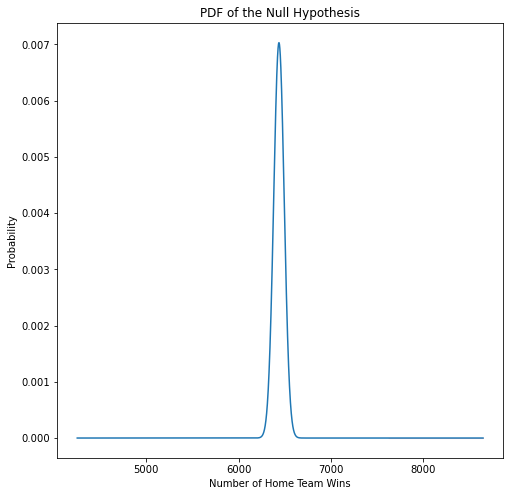

In [24]:

fig, ax = plt.subplots(figsize=(8,8))
n, p = total_games,0.5
x = np.arange(4250,8650)
ax.plot(x, norm.pdf(x))
ax.fill_between(x, norm.pdf(x), 0,
                   where=((x >= total_home_wins)),
                   color="red", alpha=0.2)
ax.set_title("PDF of the Null Hypothesis")
ax.set_ylabel("Probability")
ax.set_xlabel("Number of Home Team Wins")


Null: There is no home court advantage for the knicks. Knicks at MSG win 50% of games.

Alternative: There is home court advantage for the knicks. Knicks at MSG win more than 50% of games.

In [72]:
knicks_games = filtered[(filtered.home_team=='New York Knicks') | (filtered.visiting_team == 'New York Knicks')]

In [73]:
knicks_games

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
10,2010-04-02,2009-10 NBA Season,New York Knicks,117,Golden State Warriors,128,,1,0
28,2010-04-04,2009-10 NBA Season,New York Knicks,113,Los Angeles Clippers,107,,0,1
33,2010-04-06,2009-10 NBA Season,Boston Celtics,101,New York Knicks,104,,1,0
38,2010-04-07,2009-10 NBA Season,New York Knicks,105,Indiana Pacers,113,,1,0
54,2010-04-09,2009-10 NBA Season,New York Knicks,103,Orlando Magic,118,,1,0
...,...,...,...,...,...,...,...,...,...
12821,2018-10-22,2018-19 NBA Season,New York Knicks,113,Milwaukee Bucks,124,,1,0
12833,2018-10-24,2018-19 NBA Season,New York Knicks,87,Miami Heat,110,,1,0
12847,2018-10-26,2018-19 NBA Season,Golden State Warriors,128,New York Knicks,100,,0,1
12869,2018-10-29,2018-19 NBA Season,Brooklyn Nets,96,New York Knicks,115,,1,0


In [64]:
total_knicks_home_win = knicks_games[knicks_games.home_win==1]['home_team'].count()
total_knicks_home_win

193

In [74]:
total_knicks_games = knicks_games.shape[0]
total_knicks_games

822

In [82]:
binomial_knicks = stats.binom(n=total_knicks_games, p=0.5)

In [83]:
prob_equal_or_more_extreme = 1 - binomial_knicks.cdf(total_knicks_home_win-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 1.0


In [77]:
nets_games = filtered[(filtered.home_team=='Brooklyn Nets') | (filtered.visiting_team == 'Brooklyn Nets')]

In [78]:
nets_games

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
3710,2013-04-03,2012-13 NBA Season,Brooklyn Nets,113,Cleveland Cavaliers,95,,0,1
3720,2013-04-04,2012-13 NBA Season,Chicago Bulls,92,Brooklyn Nets,90,,0,1
3736,2013-04-06,2012-13 NBA Season,Charlotte Bobcats,96,Brooklyn Nets,105,,1,0
3752,2013-04-09,2012-13 NBA Season,Philadelphia 76ers,83,Brooklyn Nets,104,,1,0
3765,2013-04-10,2012-13 NBA Season,Brooklyn Nets,101,Boston Celtics,93,,0,1
...,...,...,...,...,...,...,...,...,...
12832,2018-10-24,2018-19 NBA Season,Brooklyn Nets,102,Cleveland Cavaliers,86,,0,1
12851,2018-10-26,2018-19 NBA Season,Brooklyn Nets,115,New Orleans Pelicans,117,,1,0
12862,2018-10-28,2018-19 NBA Season,Golden State Warriors,120,Brooklyn Nets,114,,0,1
12869,2018-10-29,2018-19 NBA Season,Brooklyn Nets,96,New York Knicks,115,,1,0


In [79]:
total_nets_home_win = nets_games[nets_games.home_win==1]['home_team'].count()
total_nets_home_win

339

In [80]:
total_nets_games = nets_games.shape[0]
total_nets_games

601

In [84]:
binomial_nets = stats.binom(n=total_nets_games, p=0.5)

In [96]:
prob_equal_or_more_extreme = 1 - binomial_nets.cdf(total_nets_home_win-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 0.00096


In [87]:
gsw_games = filtered[(filtered.home_team=='Golden State Warriors') | (filtered.visiting_team == 'Golden State Warriors')]
gsw_games

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
10,2010-04-02,2009-10 NBA Season,New York Knicks,117,Golden State Warriors,128,,1,0
25,2010-04-04,2009-10 NBA Season,Golden State Warriors,113,Toronto Raptors,112,,0,1
32,2010-04-06,2009-10 NBA Season,Golden State Warriors,94,Washington Wizards,112,,1,0
45,2010-04-07,2009-10 NBA Season,Golden State Warriors,116,Minnesota Timberwolves,107,,0,1
74,2010-04-10,2009-10 NBA Season,Golden State Warriors,104,Los Angeles Clippers,107,,1,0
...,...,...,...,...,...,...,...,...,...
12841,2018-10-24,2018-19 NBA Season,Washington Wizards,122,Golden State Warriors,144,,1,0
12847,2018-10-26,2018-19 NBA Season,Golden State Warriors,128,New York Knicks,100,,0,1
12862,2018-10-28,2018-19 NBA Season,Golden State Warriors,120,Brooklyn Nets,114,,0,1
12870,2018-10-29,2018-19 NBA Season,Golden State Warriors,149,Chicago Bulls,124,,0,1


In [89]:
total_gsw_home_win = gsw_games[gsw_games.home_win==1]['home_team'].count()
total_gsw_home_win

540

In [90]:
total_gsw_games = gsw_games.shape[0]
total_gsw_games

928

In [91]:
binomial_gsw = stats.binom(n=total_gsw_games, p=0.5)

In [95]:
prob_equal_or_more_extreme = 1 - binomial_gsw.cdf(total_gsw_home_win-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 3.4e-07
